In [422]:
# compatibility with Python 2
from __future__ import print_function

# preprocess
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.preprocessing import MinMaxScaler

# To import the classifier (SVM classifier)
from sklearn.svm import SVC

# To measure accuracy
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# computes distance between each pair of two collections of inputs
from scipy.spatial.distance import pdist

# repaired matrix by averaging; probably the best can do without domain-specific information
from sklearn.utils.validation import check_symmetric

# clustering-related methods
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score 

# dimensionality reduction
from sklearn.decomposition import PCA

# support plots
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sns; sns.set()
import networkx as nx

import numpy as np
import pandas as pd
import math

# To increase quality of figures
plt.rcParams["figure.figsize"] = (20, 7)

# display all the plots inline
%matplotlib inline

# fs-related operations
import os

# download files
import requests

#float_formatter = lambda x: "%.3f" % x
#np.set_printoptions(formatter={'float_kind':float_formatter})

# To import the scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Binarizer


class DummyScaler:
    
    def fit(self, data):
        pass
    
    def transform(self, data):
        return data

def create_scaler_dummy():
    return DummyScaler()
    
def create_scaler_standard():
    return StandardScaler()

def create_scaler_minmax():
    return MinMaxScaler()

def crete_scaler_binarizer():
    return Binarizer()

data = pd.read_excel('../c/data.xlsx') 

In [423]:
# significant imbalanced sample
data['Lab Status'].value_counts()

# adding label as a new column to data
# assign class 0 to the negative id in [lab status], class 1 to positive
# class 0 and 1 are training set, the rest is test set

data['label']= -1
data.loc[data['Lab Status'] == 'Positive ID', 'label'] = 1
data.loc[data['Lab Status'] == 'Negative ID', 'label'] = 0

In [424]:
# seperate unknown data for later
unknown_pic = data.loc[data['label']== -1]

# remove all the missing / irrelevent values
# data = data[data.label != -1]
data = data.drop('GlobalID', axis = 1)
data = data.drop('Notes', axis = 1)
data = data.drop('Lab Status', axis = 1)
data = data.drop('Submission Date', axis = 1)
data = data.drop('Lab Comments', axis = 1)

In [425]:
data.columns = ['date','lat', 'lon', 'class']
type(data.date[1])

data = data[data.date != 0]
data = data[data.lat != 0]
data = data[data.lon != 0]
data

# change datetime type into integers
from datetime import datetime
data['date'] = data['date'].astype(str)

type(data.date[3])

data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# Manually delete case with the abnormal date causing error, already done
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.head()

type(data.date[3])

data['date'] = data['date'].apply(datetime.toordinal)

# Step 1: K-Means clustering

In [426]:
df = data

# preprocess data for clustering

X = df.drop(['class'], axis = 1)
X = StandardScaler().fit_transform(df)
X

# use PCA (principal component analysis) to reduce dimension to 2 to simply visualize the data

pca_model = PCA(n_components=2)
X_reduced = pca_model.fit_transform(X)

# Here we use closure to store the related variables

def create_plot_kmeans_digits(_X, _y, _n_classes):
    X, y = _X, _y
    n_classes = _n_classes
    colors = np.array([cm.tab20(i) for i in range(100)])

# set K randomly for initialisation

    def plot_kmeans_digits(n_clusters=10):
        expand=1
        kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10, random_state=520, max_iter=1000, n_jobs=-1)
        kmeans.fit(X)
        y_predicted = kmeans.predict(X)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.plot((np.min(X_reduced[:, 0])-expand, np.max(X_reduced[:, 0])+expand), 
                 (np.min(X_reduced[:, 1])-expand, np.max(X_reduced[:, 1])+expand),
                 alpha=0.0)
        xlim = ax1.get_xlim()
        ylim = ax1.get_ylim()
        ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], c=colors[y_predicted])
        ax1.set_xlabel('pca #1')
        ax1.set_ylabel('pca #2') 
        centers = np.array(kmeans.cluster_centers_)
        ax1.scatter(centers[:, 0], centers[:, 1], marker="x", color='k', s=64)
        matrix = np.zeros((n_clusters, n_classes))
        for cluster in range(n_clusters):
            for cl in range(n_classes):
                matrix[cluster, cl] = np.sum(y[y_predicted == cluster]==cl)
        sns.heatmap(matrix, annot=True, fmt='g', ax=ax2)
        ax2.set_xlabel('Class')
        ax2.set_ylabel('Cluster')
        print('Inertia:', kmeans.inertia_)
        plt.savefig('../c/KmeansFindK.png')
        plt.show()
    return plot_kmeans_digits

n_clusters_widget = widgets.IntSlider(
    value=1,
    min=1,
    max=20,
    step=1,
    continuous_update=False,
    description='N clusters:')
interact(create_plot_kmeans_digits(X_reduced, y_predicted, 10),
         n_clusters=n_clusters_widget)

interactive(children=(IntSlider(value=1, continuous_update=False, description='N clusters:', max=20, min=1), O…

<function __main__.create_plot_kmeans_digits.<locals>.plot_kmeans_digits(n_clusters=10)>

In [427]:
# If class labels are not available, within-cluster sum of squares (inertia) can be used
# inertia: how far away the points within a cluster are，the smaller the better

n_clusters = range(1, 30)
inertia = np.zeros(len(n_clusters))
for i, clusters in enumerate(n_clusters):
    kmeans = KMeans(init='k-means++', n_clusters=clusters, n_init=10, random_state=520, max_iter=1000, n_jobs=-1)
    kmeans.fit(X)
    inertia[i] = kmeans.inertia_
    y_predicted = kmeans.predict(X)

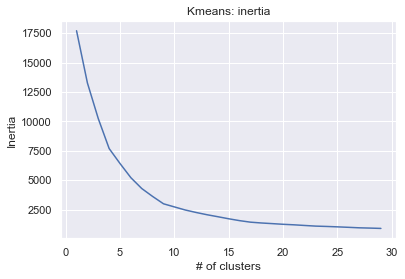

In [428]:
plt.plot(n_clusters, inertia)
plt.title('Kmeans: inertia')
plt.xlabel('# of clusters')
plt.ylabel('Inertia')
plt.savefig('../c/KmeansInertia.png')
plt.show()

In [429]:
# try for 10

k_means = KMeans(n_clusters=10)

#Run the clustering algorithm
model = k_means.fit(X)
model

#Generate cluster predictions and store in y_hat
y_hat = k_means.predict(X)

labels = k_means.labels_

# Calculating the silhouette coefficient, A high value is desirable
print(metrics.silhouette_score(X, labels, metric = 'euclidean'))

# CH score, A high value is desirable
print(metrics.calinski_harabasz_score(X, labels))

0.4912524609314346
2700.458935502707


In [430]:
# try for other number of clusters (= 4)
k_means_4 = KMeans(n_clusters=4)
model = k_means_4.fit(X)
y_hat_4 = k_means_4.predict(X)
labels_4 = k_means_4.labels_
print(metrics.silhouette_score(X, labels_4, metric = 'euclidean'))
print(metrics.calinski_harabasz_score(X, labels_4))

0.4549379492146976
1922.447744388791


In [431]:
# try for other number of clusters (= 3)
k_means_3 = KMeans(n_clusters=3)
model = k_means_3.fit(X)
y_hat_3 = k_means_3.predict(X)
labels_3 = k_means_3.labels_
print(metrics.silhouette_score(X, labels_3, metric = 'euclidean'))
print(metrics.calinski_harabasz_score(X, labels_3))

0.4408457620147509
1616.0288563480335


In [432]:
# try for other number of clusters (= 9)
k_means_9 = KMeans(n_clusters=9)
model = k_means_9.fit(X)
y_hat_9 = k_means_9.predict(X)
labels_9 = k_means_9.labels_
print(metrics.silhouette_score(X, labels_9, metric = 'euclidean'))
print(metrics.calinski_harabasz_score(X, labels_9))

0.48540678225788625
2721.7572942052434


In [433]:
# try for other number of clusters (=5)
k_means_5 = KMeans(n_clusters=5)
model = k_means_5.fit(X)
y_hat_5 = k_means_5.predict(X)
labels_5 = k_means_5.labels_
print(metrics.silhouette_score(X, labels_5, metric = 'euclidean'))
print(metrics.calinski_harabasz_score(X, labels_5))

0.4779765080063154
1946.319333136316


In [434]:
# try for other number of clusters (=15)
k_means_15 = KMeans(n_clusters=15)
model = k_means_15.fit(X)
y_hat_15 = k_means_15.predict(X)
labels_15 = k_means_15.labels_
print(metrics.silhouette_score(X, labels_15, metric = 'euclidean'))
print(metrics.calinski_harabasz_score(X, labels_15))

0.46715418713131995
2951.3957879107024


In [435]:
# if choose n_clusters = 10, the clusters will be two small for svm
# but can use clusters as one more features for svm
#add label to the original dataframe

df['KmeansCluster'] = labels

In [436]:
df.columns

Index(['date', 'lat', 'lon', 'class', 'KmeansCluster'], dtype='object')

In [437]:
new_columns = ['date', 'lat', 'lon', 'KmeansCluster', 'class']

In [438]:
df = df.reindex(columns = new_columns)

# Step 2 : Class_Weighted SVM - RBF

In [439]:
# SVM model on all df data
whole = df.loc[df['class'] != -1]

whole_un = df.loc[df['class'] == -1]
whole_un = whole_un.drop('class', 1)


# split to X and y
# X is all the features' data, y is all the class data
whole_vals = whole.values
X = whole_vals[:, :-1]
y = whole_vals[:, -1]

In [440]:
# split the data into train and test set（10%）randomly
# scale the data before using SVM

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000)

create_scaler = create_scaler_minmax
scaler = create_scaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [441]:
svm_clf = SVC(kernel='rbf', gamma='auto')
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

# performance
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.99      1.00      1.00       620
     class 1       0.00      0.00      0.00         5

    accuracy                           0.99       625
   macro avg       0.50      0.50      0.50       625
weighted avg       0.98      0.99      0.99       625



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [442]:
predic_class_whole = svm_clf.predict(whole_un.values)

In [443]:
whole_un['predic_class'] = predic_class_whole

In [444]:
whole_un['predic_class'].astype(int)

2       0
4       0
5       0
7       0
10      0
       ..
4421    0
4422    0
4423    0
4424    0
4425    0
Name: predic_class, Length: 2344, dtype: int64

In [445]:
whole_un.loc[whole_un['predic_class'] == 1]

,date,lat,lon,KmeansCluster,predic_class


***Reference***
1. imbalance data 

https://towardsdatascience.com/how-to-deal-with-imbalanced-data-34ab7db9b100

should upsample the data (<10k), check performance matrics

https://stats.stackexchange.com/questions/122095/does-support-vector-machine-handle-imbalanced-dataset

https://stats.stackexchange.com/questions/94295/svm-for-unbalanced-data

class weighted SVM

https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html

   
2. change datetime type into integers 

https://www.geeksforgeeks.org/python-pandas-timestamp-toordinal/

3. supervised clustering 

https://stats.stackexchange.com/questions/37587/supervised-clustering-or-classification

4. kmeans normalization

https://datascience.stackexchange.com/questions/6715/is-it-necessary-to-standardize-your-data-before-clustering

5. find best k for kmeans

https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

6. cluster then classify

https://towardsdatascience.com/cluster-then-predict-for-classification-tasks-142fdfdc87d6